# Competition: Modulation format classification

#### Solution using a convolutional neural network

Enter your team name here:

In [1]:
# Bevore you start, please enter your team name!
team_name = 'REFERENCE_CONVNN'

The main code starts here...

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

In [3]:
# In case you want to use PyTorch to build you clasifier
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Helper code that computes the the classification error rate, i.e. $\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y})$, an estimate of the error probability. The classification is obtained from $N$ pairs $(\pmb{x}_i, y_i)$, $i=1,\ldots, N$ and the corresponding estimates $\hat{y}_i = f(\pmb{x}_i)$ as follows
$$
\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y}) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{\{f(\pmb{x}_i) \neq y_i\}}
$$
where $\mathbb{1}_{\{E\}}$ is the indicator function, which returns 1 if the event $E$ is true and 0 otherwise

In [4]:
# helper function to compute the classification error rate.
def CER(predictions, labels):
    """Calculates the classification error rate."""
    return (np.sum(predictions != labels) / len(predictions))

This is a helper function that double-checks if the data is correct and carries out some sanity-checks.

In [5]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions, valid_values):
    """Chcecks if predicitions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')
    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')
    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')
    all_values_valid = True
    for i in range(len(predictions)):
        if (predictions[i] not in valid_values):
            print('All values of "predictions" have to be in "valid data".')
            all_values_valid = False
            break
    if all_values_valid:
        print('Predictions are valid values.')

In [6]:
# Checks if the data you upload has the correct type/form
def check_predicitions_regression(test_data, predictions):
    """Chcecks if predicitions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')
    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')
    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')

## Task 1: Distinguish between BPSK and QPSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. 

Show the classification error for the validation set for each SNR point separately.

Load datasets. They are stored as a pickle file.

The dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

In [7]:
# Download data sets if they are not available
from os.path import exists
import urllib.request
    
if not exists('MLOC_Competition_2023_task1_dataset_train.pkl'):
    print('Downloading data set file 1/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_train.pkl', 'MLOC_Competition_2023_task1_dataset_train.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_dataset_valid.pkl'):
    print('Downloading data set file 2/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_valid.pkl', 'MLOC_Competition_2023_task1_dataset_valid.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_test_data.pkl'):
    print('Downloading data set file 3/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_test_data.pkl', 'MLOC_Competition_2023_task1_test_data.pkl')        
    print('done')

In [8]:
# Load training dataset
with open('MLOC_Competition_2023_task1_dataset_train.pkl', "rb") as f:
    X_train_task_1 = pickle.load(f)
    y_train_task_1 = pickle.load(f)
    SNR_train_task_1 = pickle.load(f)
    modulation_formats_task_1 = pickle.load(f)
    SNRs_task_1 = pickle.load(f)
    
# Load validation dataset
with open('MLOC_Competition_2023_task1_dataset_valid.pkl', "rb") as f:
    X_valid_task_1 = pickle.load(f)
    y_valid_task_1 = pickle.load(f)
    SNR_valid_task_1 = pickle.load(f) 
    
# Load test data
with open('MLOC_Competition_2023_task1_test_data.pkl', "rb") as f:
    X_test_task_1 = pickle.load(f)

Print modulation formats ans SNR values which are used:

In [9]:
print('Modulation formats: ', modulation_formats_task_1)
print('SNR values: ', SNRs_task_1)

Modulation formats:  ['BPSK', 'QPSK']
SNR values:  [-10  -8  -6  -4  -2   0   2   4]


Plot 6 random signal traces

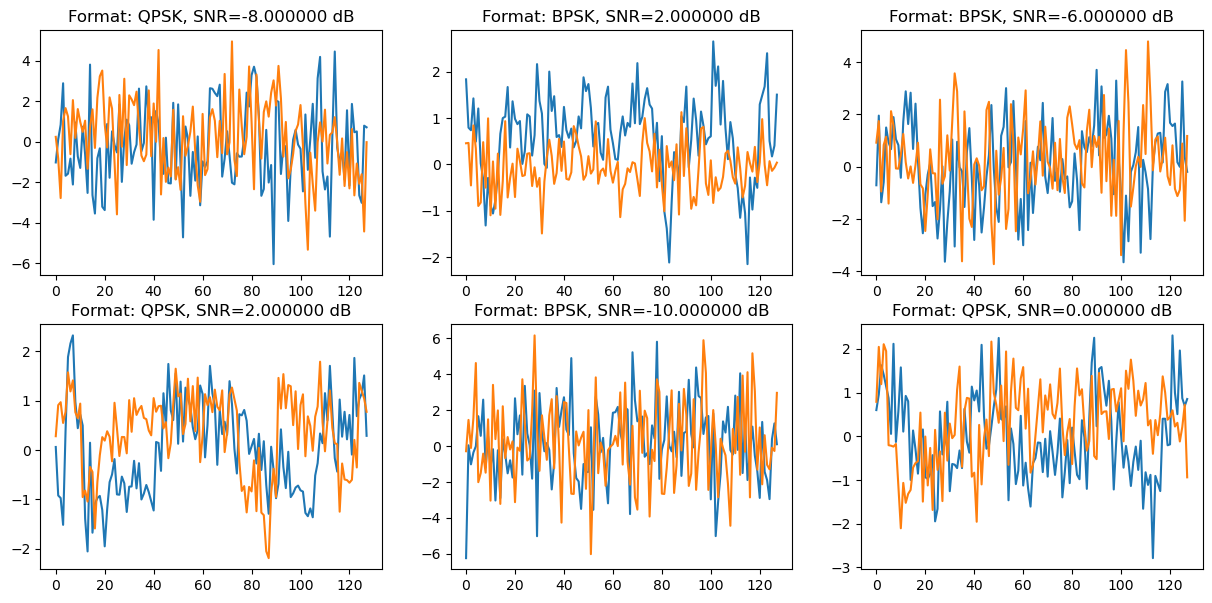

In [10]:
starti = np.random.randint(0,X_train_task_1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_1[k+starti,:]))
    plt.plot(np.imag(X_train_task_1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats_task_1[y_train_task_1[k+starti]], SNR_train_task_1[k+starti]))    

In [11]:
# prepare data, convert complex data to real and imaginary parts
X_train_torch = torch.from_numpy( np.stack((np.real(X_train_task_1), np.imag(X_train_task_1)), 1) ).to(device)

X_valid_torch = torch.from_numpy( np.stack((np.real(X_valid_task_1), np.imag(X_valid_task_1)), 1) ).to(device)

y_train_torch = torch.from_numpy(y_train_task_1).type(torch.float32).to(device)
y_valid_torch = torch.from_numpy(y_valid_task_1).type(torch.float32).to(device)


Use a neural network with three 1-dimensional convolutional layers and one fully connected linear output layer.

We use the ELU function as nonlinear activation function and the binary cross entropy as loss function.

In [28]:
# Define Neural Network
class ConvNN_Task_1(nn.Module):
    def __init__(self):
        super(ConvNN_Task_1, self).__init__()
        # Linear function, 256 input neurons (real and imaginary part, with each 128 samples)        
        self.conv1d_1 = nn.Conv1d(2,6,35,padding='same'); 
        self.conv1d_2 = nn.Conv1d(6,3,35,padding='same');         
        self.conv1d_3 = nn.Conv1d(3,1,17,stride=8);         
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)
        
        # Non-linearity
        self.activation_function = nn.ELU()

        # Output layer, 1 output, as simple binary decision
        self.fc = nn.Linear(14, 1)
        
    def forward(self, x):
        # Linear function, first layer
        out = self.conv1d_1(x)
        # Non-linearity, first layer
        out = self.activation_function(out)

        # Dropout
        out = self.dropout(out)
                
        out = self.conv1d_2(out)
        out = self.activation_function(out)

        # Dropout
        out = self.dropout(out)        
        
        out = self.conv1d_3(out)
        out = self.activation_function(out).squeeze()        
        
        # Fully connected linear output layer
        out = self.fc(out)    
        return out


# Binary Cross Entropy loss function, use logits as input
loss_fn = nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()

Implement the training of the model. Here we use a mini-batch size of 320, so that the training data set is subdivided into 2000 batches. We reuse each mini-batch 40 times, and each time is an epoch. The Adam optimizer with a learning rate of $5\times 10^{-3}$ is used.

In [23]:
### possible solution here ###
batches_per_epoch = 2000
samples_per_batch = int(np.floor(len(X_train_torch)/batches_per_epoch))

# reuse the data 40 times
num_epochs = 40

model = ConvNN_Task_1()
model.to(device)


# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Start Training
print('Train over all SNRs')
validation_CERs = np.zeros(num_epochs)

best_CER = 1
for epoch in range(num_epochs):             
    # Put model in training mode (necessary here to activate dropout)
    model.train()
    for step in range(batches_per_epoch):
        
        # Send data trough net
        outputs = model(X_train_torch[int(step*samples_per_batch):int((step+1)*samples_per_batch), :, :])

        # compute loss
        loss = loss_fn(outputs.squeeze(), y_train_torch[int(step*samples_per_batch):int((step+1)*samples_per_batch)].squeeze())

        # compute gradients
        loss.backward()

        # Update weights
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()
    
    # Put model in evaluation mode (necessary to deactivate dropout)
    model.eval()
    out_valid = sigmoid(model(X_valid_torch)) > 0.5
    validation_CERs[epoch] = CER(out_valid.detach().cpu().numpy().squeeze(), y_valid_task_1)
    print('Validation CER after epoch %d: %f (loss %1.8f)' % (epoch, validation_CERs[epoch], loss.detach().cpu().numpy()), end='')
    
    # save the best model from validation for future use
    if validation_CERs[epoch] < best_CER:
        best_CER = validation_CERs[epoch]
        best_model = copy.deepcopy(model)
        print(' ... saving model')
    else:
        print('')
            

Train over all SNRs
Validation CER after epoch 0: 0.037992 (loss 0.12243924) ... saving model
Validation CER after epoch 1: 0.037680 (loss 0.10667572) ... saving model
Validation CER after epoch 2: 0.039438 (loss 0.10037827)
Validation CER after epoch 3: 0.038812 (loss 0.11501306)
Validation CER after epoch 4: 0.041625 (loss 0.12805896)
Validation CER after epoch 5: 0.042398 (loss 0.12778834)
Validation CER after epoch 6: 0.040930 (loss 0.10625928)
Validation CER after epoch 7: 0.043117 (loss 0.12606230)
Validation CER after epoch 8: 0.043016 (loss 0.09745390)
Validation CER after epoch 9: 0.045086 (loss 0.09370211)
Validation CER after epoch 10: 0.044656 (loss 0.10649874)
Validation CER after epoch 11: 0.043828 (loss 0.10058627)
Validation CER after epoch 12: 0.043602 (loss 0.08441672)
Validation CER after epoch 13: 0.043594 (loss 0.10243928)
Validation CER after epoch 14: 0.042578 (loss 0.11602335)
Validation CER after epoch 15: 0.044102 (loss 0.09748532)
Validation CER after epoch 1

Implement the classifier using the trained model. Therefore, first convert the data to a PyTorch tensor and then apply the model

In [24]:
# This is the final classified using the best learned model weights
def BPSK_QPSK(data):    
    best_model.eval()
    data_torch = torch.from_numpy( np.stack((np.real(data.squeeze()), np.imag(data.squeeze())), 1) ).to(device)    
    
    # Use the weights obtained earlier    
    classification = sigmoid(best_model(data_torch)).detach().cpu().numpy().squeeze() > 0.5    
    return classification

In [25]:
# Validate results
idx_SNR_valid = []
for i in range(len(SNRs_task_1)):
    idx_SNR_valid.append(np.asarray(np.where(SNR_valid_task_1 == SNRs_task_1[i])))    

error_rates_single_SNR = np.empty([len(SNRs_task_1)])
for SNR in range(len(SNRs_task_1)):   
    # Get data coresponding to the SNR value
    X_valid_single_SNR = X_valid_task_1[idx_SNR_valid[SNR]]
    y_valid_single_SNR = y_valid_task_1[idx_SNR_valid[SNR]]    
    
    yh = BPSK_QPSK(X_valid_single_SNR)    
    error_rates_single_SNR[SNR] = CER(yh, y_valid_single_SNR)    

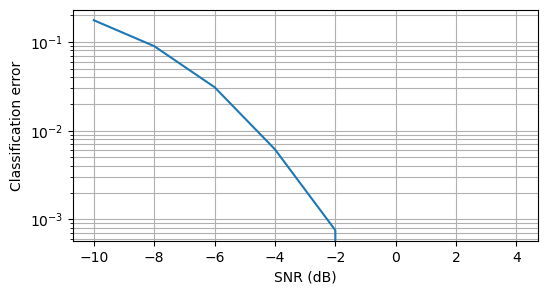

In [26]:
# Plot Results    
plt.figure(figsize=(6,3))
plt.semilogy(SNRs_task_1, error_rates_single_SNR)
plt.xlabel('SNR (dB)')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.savefig('Example_result.pdf',bbox_inches='tight')

In [27]:
# Send test data through the classifier
predictions_task_1 = BPSK_QPSK(X_test_task_1)


# Write predictions to file including sanity check
### Don't touch this part
check_predictions(X_test_task_1, predictions_task_1, range(len(modulation_formats_task_1)))

with open('Task_1_%s.pkl' % team_name,'wb') as f:
    pickle.dump(predictions_task_1,f)

type ok.
dim ok.
length ok.
Predictions are valid values.
